In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from matplotlib.colors import LinearSegmentedColormap

In [143]:
def get_latest_csv(directory):
    list_of_files = glob.glob(os.path.join(directory, '*.csv'))
    if not list_of_files:
        raise FileNotFoundError("No CSV files found in the directory.")
    latest_file = max(list_of_files, key=os.path.getmtime)
    print(f"Using file: {latest_file}")
    return latest_file

In [144]:
def plot_boxplot_by_model(df, save=False):
    df_melted = df.melt(id_vars='model', value_vars=['Novelty', 'Plausibility'],
                        var_name='Metric', value_name='Score')

    # Custom color palette for consistency
    palette = {'Novelty': '#1f77b4', 'Plausibility': '#ff7f0e'}

    plt.figure(figsize=(10, 6))
    ax = sns.boxenplot(data=df_melted, x='model', y='Score', hue='Metric', palette=palette, gap=0.1)

    ax.set_title("Distribution of Novelty and Plausibility by Model", fontsize=16)
    ax.set_xlabel("Model", fontsize=14, labelpad=15)
    ax.set_ylabel("Score (1–10)", fontsize=14)
    ax.set_ylim(0.5, 10.5)
    ax.set_yticks(range(1, 11))
    ax.legend(title='Metric', bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    if save:
        plt.savefig("figures/boxplot_by_model.png", dpi=300)
    plt.show()

In [145]:
def plot_jointplot_by_model(df, save=False):
    models = df['model'].unique()
    for model in models:
        df_model = df[df['model'] == model]
        g = sns.jointplot(data=df_model, x="Novelty", y="Plausibility", kind="kde",
                          cmap="mako", height=6, space=0.3, fill=True)

        # g.plot_joint(sns.scatterplot, s=40, color='black', alpha=0.6, edgecolor="white")
        g.ax_joint.set_xlim(0.5, 10.5)
        g.ax_joint.set_ylim(0.5, 10.5)
        g.ax_joint.set_xticks(range(1, 11))
        g.ax_joint.set_yticks(range(1, 11))
        g.ax_joint.set_title(f"Novelty vs. Plausibility for {model}", fontsize=14, pad=70)
        g.set_axis_labels("Novelty", "Plausibility", fontsize=12)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        if save:
            plt.savefig(f"figures/jointplot_{model}.png", dpi=300)
        plt.show()

In [146]:
def plot_score_distributions_grid(df, save=False):
    # Step 1: Parse method using slicing
    method_map = {
        'LGBM': 'LightGBM',
        'XGBS': 'XGBoost',
        'LIFT': 'Lift'
    }
    df['METHOD'] = df['hypothesis_id'].str[0:4].map(method_map)

    # Step 2: Melt novelty and plausibility
    df_melted = df.melt(id_vars=['METHOD', 'model'],
                        value_vars=['Novelty', 'Plausibility'],
                        var_name='Metric', value_name='Score')

    # Step 3: Plotting setup
    sns.set(style='whitegrid', palette='pastel', font_scale=1.1)
    g = sns.FacetGrid(df_melted, row='METHOD', col='model', hue='Metric',
                      sharex=True, sharey=True, height=3.5, aspect=1.2, margin_titles=True)

    # Step 4: Map KDE plots
    g.map(sns.kdeplot, 'Score', fill=True, alpha=0.6, common_norm=False)

    # Final touches
    g.add_legend(title="Metric")
    g._legend.set_bbox_to_anchor((1, 1))  # top right corner outside grid
    g._legend.set_frame_on(True)
    g.set_axis_labels("Score (1–10)", "Density")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    for ax in g.axes.flat:
        ax.set_xlim(0.5, 10.5)
        ax.set_facecolor("white")

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Score Distributions by Method and Model", fontsize=16)

    plt.tight_layout()
    if save:
        plt.savefig("figures/score_distributions_grid.png", dpi=300)
    plt.show()

In [147]:
def plot_model_score_correlation_heatmaps(df, save=False):
    """
    Creates a grid with 2 heatmaps showing the correlation between models
    for Novelty and Plausibility scores respectively, with separate white-to-color colorbars.
    """
    palette = {'Novelty': '#1f77b4', 'Plausibility': '#ff7f0e'}

    # Pivot the data
    novelty_matrix = df.pivot(index='hypothesis_id', columns='model', values='Novelty')
    plausibility_matrix = df.pivot(index='hypothesis_id', columns='model', values='Plausibility')

    # Correlations
    novelty_corr = novelty_matrix.corr()
    plausibility_corr = plausibility_matrix.corr()

    # Custom colormaps: white → target color
    cmap_novelty = LinearSegmentedColormap.from_list('novelty_cmap', ['white', palette['Novelty']])
    cmap_plausibility = LinearSegmentedColormap.from_list('plausibility_cmap', ['white', palette['Plausibility']])

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    sns.heatmap(novelty_corr, ax=axes[0], annot=True, cmap=cmap_novelty, vmin=0, vmax=1,
                square=True, cbar=True, fmt=".2f", cbar_kws={'label': 'Correlation'})
    axes[0].set_title("Model Correlation – Novelty", fontsize=14)

    sns.heatmap(plausibility_corr, ax=axes[1], annot=True, cmap=cmap_plausibility, vmin=0, vmax=1,
                square=True, cbar=True, fmt=".2f", cbar_kws={'label': 'Correlation'})
    axes[1].set_title("Model Correlation – Plausibility", fontsize=14)

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    if save:
        plt.savefig("figures/model_correlation_heatmaps.png", dpi=300, bbox_inches='tight')

    plt.show()

In [148]:
latest_csv_path = get_latest_csv("llm_results")
llm_results = pd.read_csv(latest_csv_path)
llm_results = llm_results.rename(columns={'novelty': 'Novelty', 'plausibility': 'Plausibility'})
model_name_mapping = {
        'openai:gpt-4o': 'OpenAI GPT-4o',
        'openai:o3-mini': 'OpenAI o3-mini',
        'anthropic:claude-3-7-sonnet-latest': 'Claude 3.7 Sonnet'
    }
llm_results['model'] = llm_results['model'].map(model_name_mapping)
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

Using file: llm_results/evaluations_20250429_145424.csv


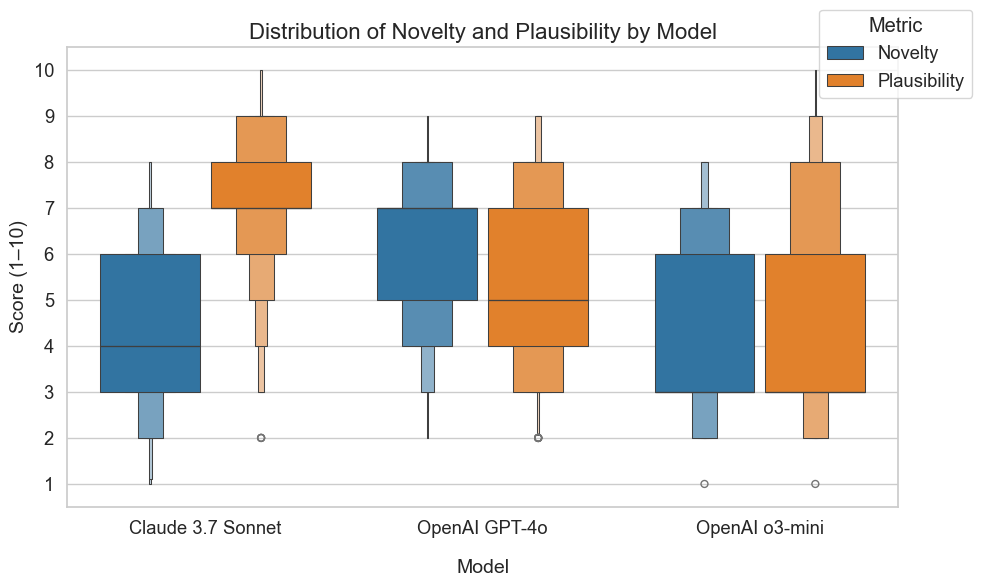

In [149]:
plot_boxplot_by_model(llm_results, save=True)

/var/folders/sl/jy0q_s_94s389s75171djrp40000gn/T/ipykernel_87462/1267522715.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


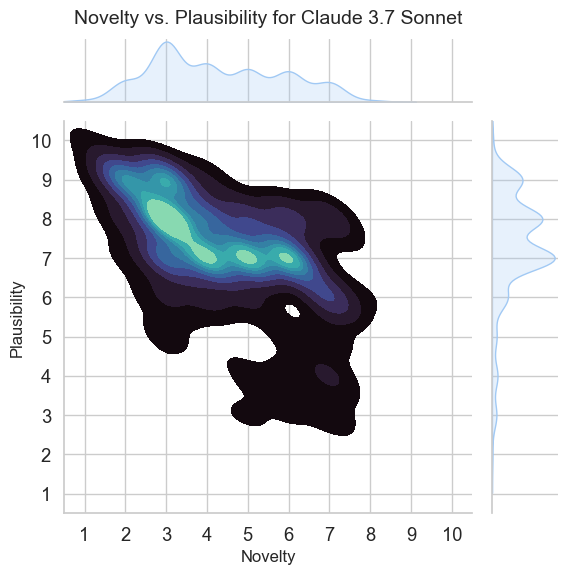

/var/folders/sl/jy0q_s_94s389s75171djrp40000gn/T/ipykernel_87462/1267522715.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


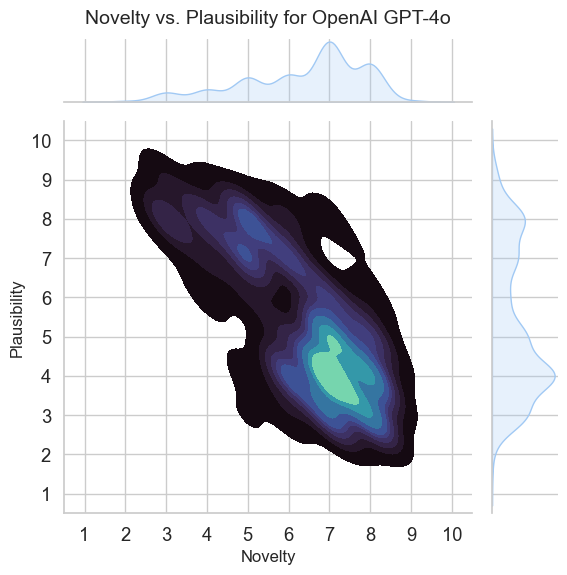

/var/folders/sl/jy0q_s_94s389s75171djrp40000gn/T/ipykernel_87462/1267522715.py:15: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


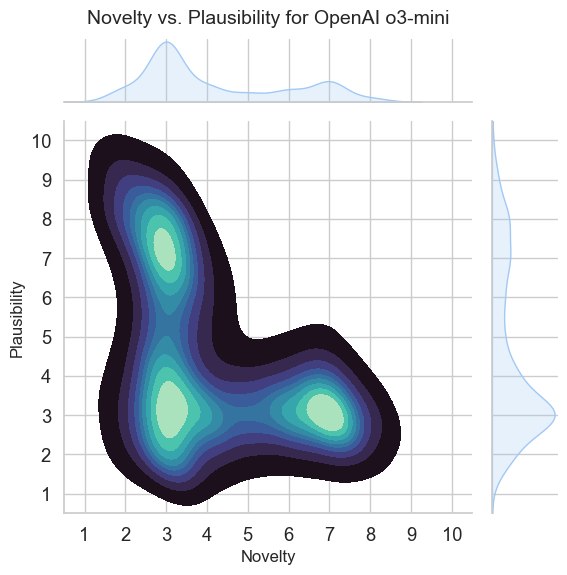

In [150]:
plot_jointplot_by_model(llm_results, save=True)

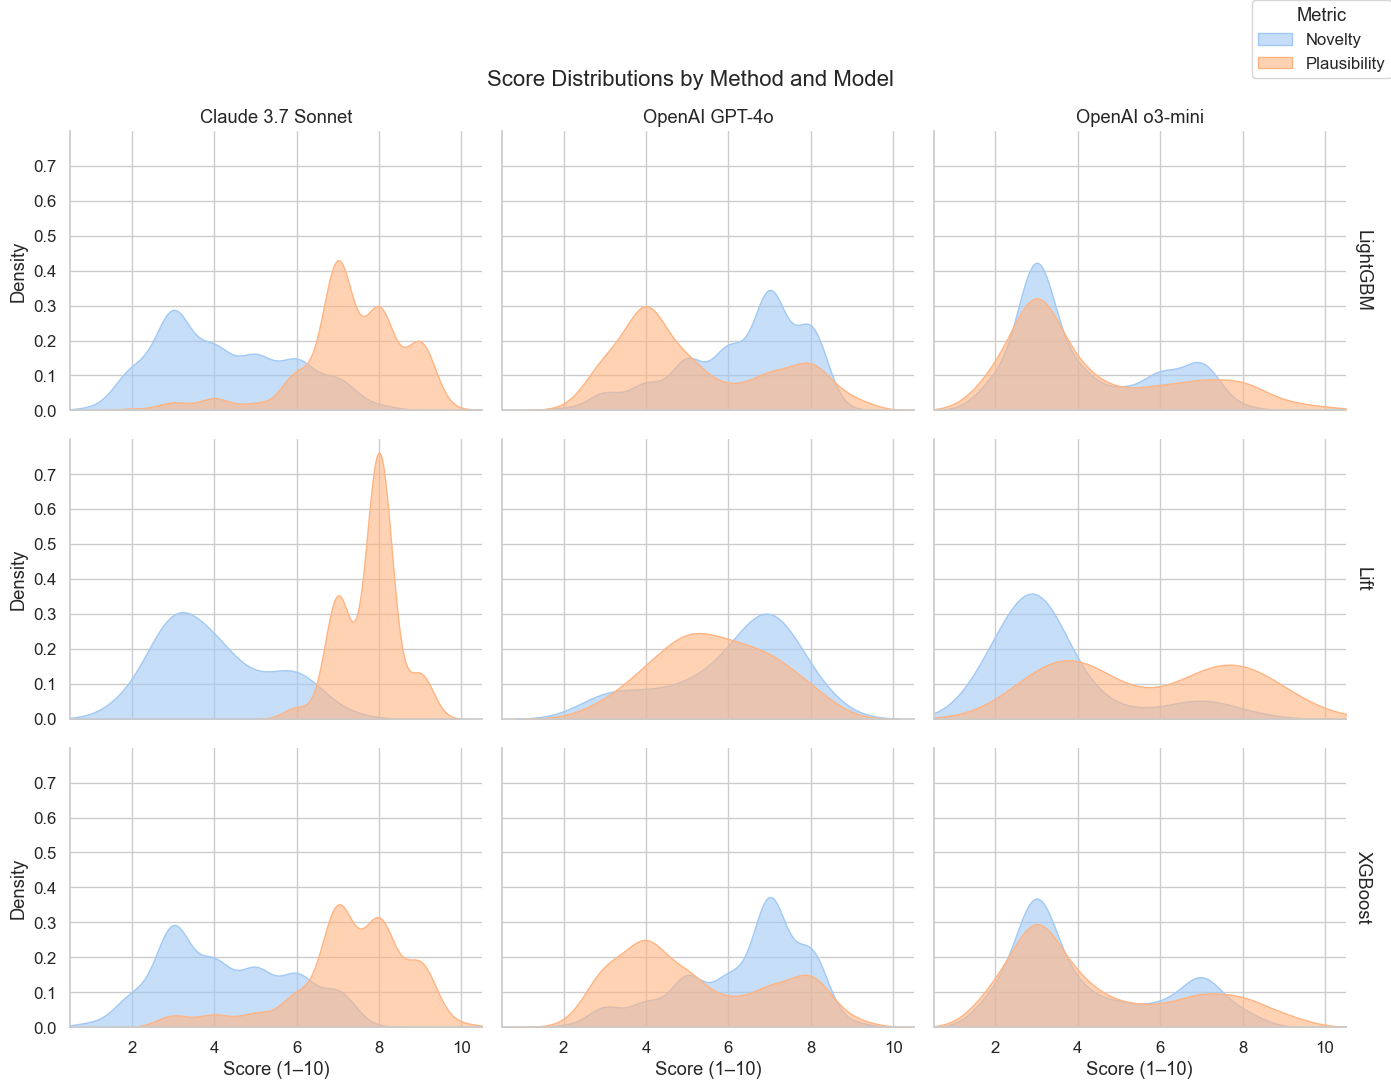

In [151]:
plot_score_distributions_grid(llm_results, save=True)

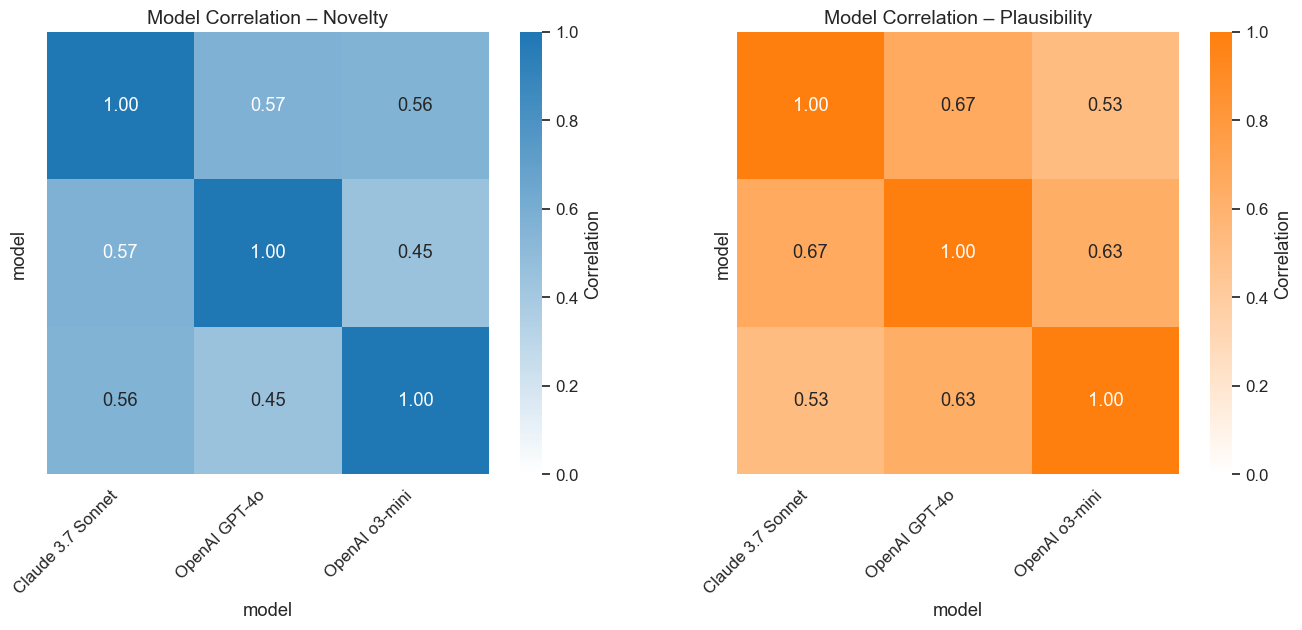

In [152]:
plot_model_score_correlation_heatmaps(llm_results, save=True)